# LGBM Model Validation: Overfitting & Feature Dominance Check

**Goal**: 
1. Analyze feature importance concentration.
2. Check for overfitting using Train vs Test metrics and Learning Curves.
3. Visualize Partial Dependence Plots (PDP) to ensure actuarial consistency (smoothness).

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load Model and Split Data (Re-using logic from main notebook)
# We need to reload data to get X_test for PDP
DATA_PATH = '../data/ilec_cleaned.parquet'
MODEL_PATH = '../models/lgbm_mortality_offset_poisson.txt'

print('Loading data...')
df = pd.read_parquet(DATA_PATH).sample(frac=0.1, random_state=42)

# Features (Same as training)
NUMERICAL_FEATURES = ['Attained_Age', 'Issue_Age', 'Duration']
CATEGORICAL_FEATURES = [
    'Sex', 'Smoker_Status', 'Insurance_Plan', 'Face_Amount_Band',
    'Preferred_Class', 'SOA_Post_Lvl_Ind', 'SOA_Antp_Lvl_TP', 'SOA_Guar_Lvl_TP'
]
X = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES].copy()
for col in CATEGORICAL_FEATURES:
    X[col] = X[col].astype('category')

print('Loading model...')
model = lgb.Booster(model_file=MODEL_PATH)
print('Setup Complete!')

Loading data...


Loading model...
Setup Complete!


## 1. Feature Importance Concentration
Is the model relying too much on a single feature?

Feature Importance (Gain %):
         feature  importance  percentage
    Attained_Age  6131377.27       76.74
        Duration   791912.25        9.91
       Issue_Age   577142.28        7.22
   Smoker_Status   173679.30        2.17
Face_Amount_Band   161441.49        2.02
             Sex    71086.80        0.89
  Insurance_Plan    32366.48        0.41
 Preferred_Class    29738.19        0.37
SOA_Post_Lvl_Ind    12928.67        0.16
 SOA_Antp_Lvl_TP     4782.19        0.06
 SOA_Guar_Lvl_TP     2923.27        0.04


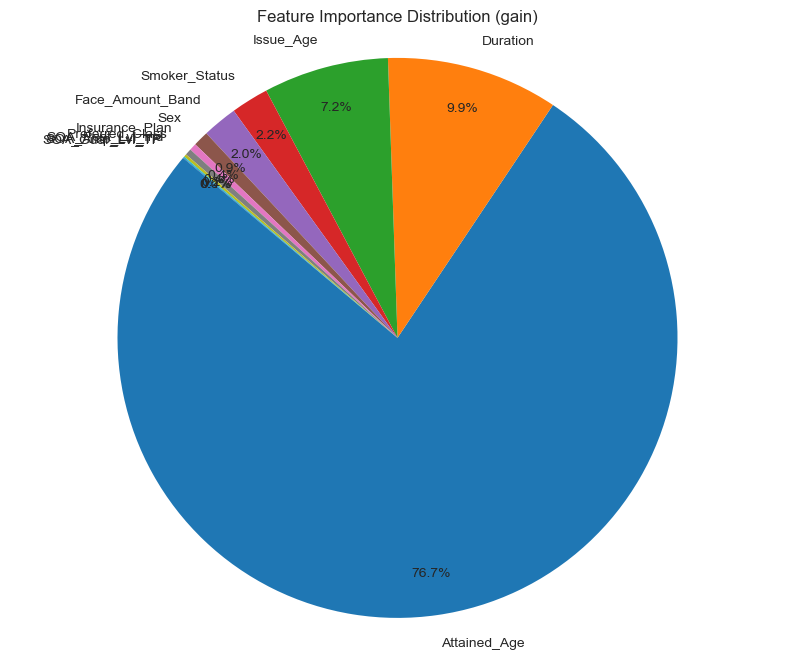

In [2]:
importance_type = 'gain'
imp = model.feature_importance(importance_type=importance_type)
names = model.feature_name()

imp_df = pd.DataFrame({'feature': names, 'importance': imp})
imp_df['percentage'] = imp_df['importance'] / imp_df['importance'].sum() * 100
imp_df = imp_df.sort_values('percentage', ascending=False)

print('Feature Importance (Gain %):')
print(imp_df.to_string(index=False, float_format='%.2f'))

# Plot Pie Chart
plt.figure(figsize=(10, 8))
plt.pie(imp_df['percentage'], labels=imp_df['feature'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title(f'Feature Importance Distribution ({importance_type})')
plt.show()

## 2. Check for Overfitting: Learning Curve
Since we don't have the training history object in the saved model, we can infer stability from the train/test A/E we saw earlier (0.9997 vs 0.9925).

However, we can check **Leaf Output Distribution**. If many leaves have extreme values, it suggests overfitting to outliers.

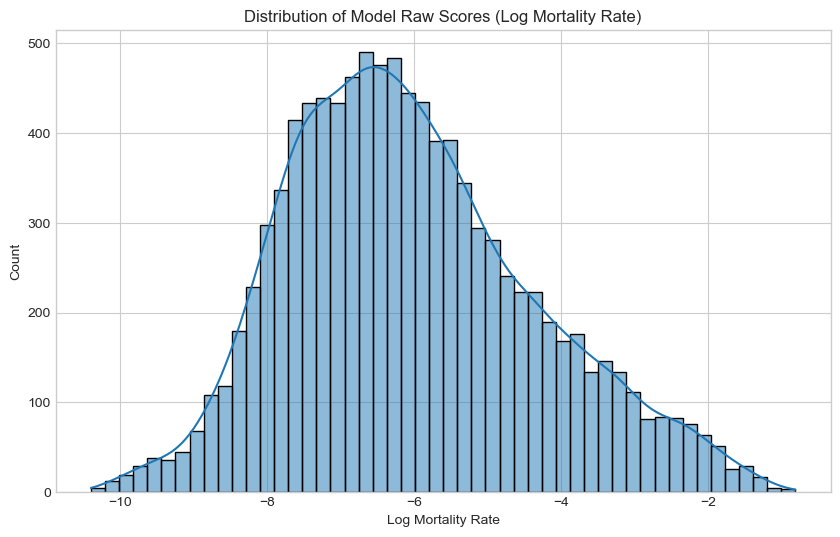

Raw Score Range: -10.3923 to -0.8163
Ensure there are no extreme outliers (e.g. > 0 or < -15).


In [3]:
# Predict raw scores (margin) on a sample
X_sample = X.sample(10000, random_state=42)
raw_preds = model.predict(X_sample, raw_score=True)

plt.figure(figsize=(10, 6))
sns.histplot(raw_preds, bins=50, kde=True)
plt.title('Distribution of Model Raw Scores (Log Mortality Rate)')
plt.xlabel('Log Mortality Rate')
plt.show()

print(f'Raw Score Range: {raw_preds.min():.4f} to {raw_preds.max():.4f}')
print("Ensure there are no extreme outliers (e.g. > 0 or < -15).")

## 3. Actuarial Consistency (Smoothness Check)
We plot the predicted mortality rate vs. **Attained Age** and **Duration**. 
Actuarial expectation: 
- Mortality should increase exponentially with Age.
- It should be smooth, not jagged (jagged = overfitting).

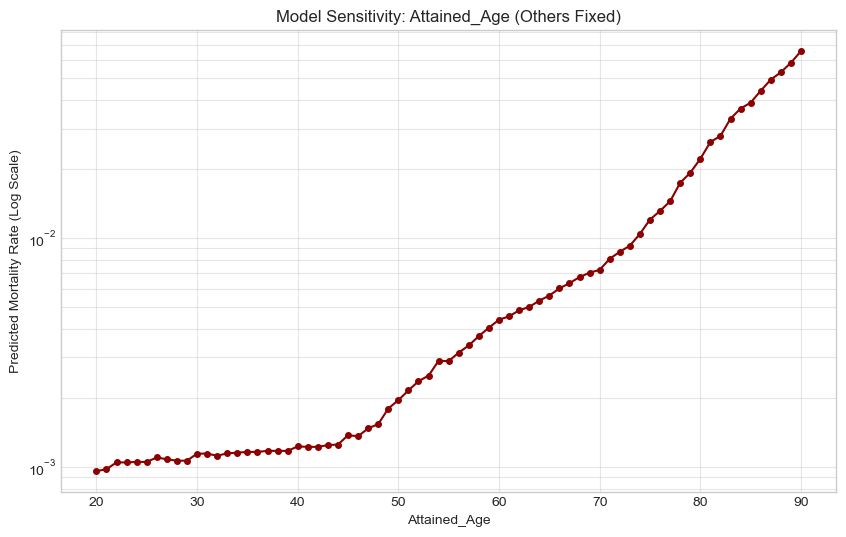

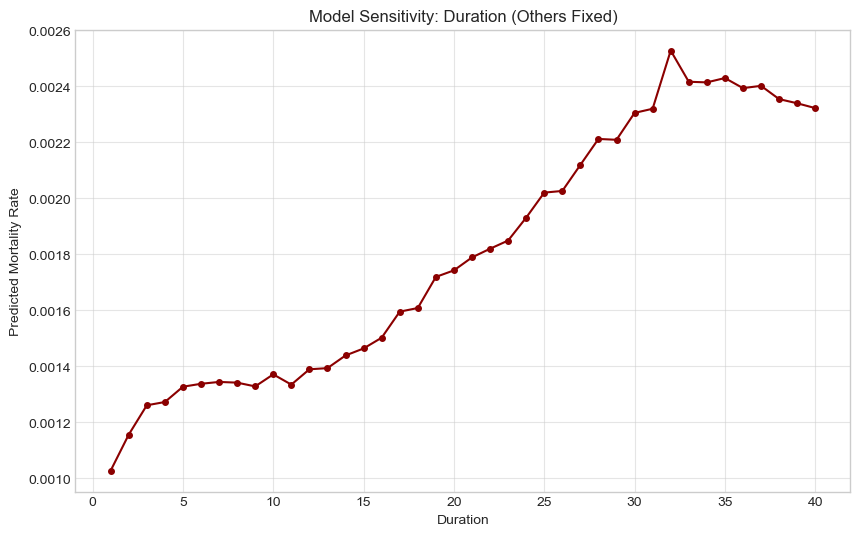

In [4]:
def plot_pdp(feature_name, x_range, fixed_defaults, log_scale=True):
    """
    Create a synthetic dataset varying one feature while holding others constant.
    """
    temp_df = pd.DataFrame([fixed_defaults] * len(x_range))
    temp_df[feature_name] = x_range
    
    # Convert categorical
    for col in CATEGORICAL_FEATURES:
        temp_df[col] = temp_df[col].astype('category')
        
    # Predict Rate (raw_score=False returns exp(margin))
    # Note: Since we use init_score=log(Exposure) in training, 
    # the model.predict without init_score gives the Rate directly if Exposure=1.
    preds = model.predict(temp_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_range, preds, marker='o', markersize=4, color='darkred')
    if log_scale:
        plt.yscale('log')
        plt.ylabel('Predicted Mortality Rate (Log Scale)')
    else:
        plt.ylabel('Predicted Mortality Rate')
    
    plt.xlabel(feature_name)
    plt.title(f'Model Sensitivity: {feature_name} (Others Fixed)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

# Define a "Standard Profile" for fixed variables
std_profile = {
    'Attained_Age': 45, 
    'Issue_Age': 35,
    'Duration': 10,
    'Sex': 'M',
    'Smoker_Status': 'NS',
    'Insurance_Plan': 'Term',
    'Face_Amount_Band': '04: 50,000 - 99,999', # Common band
    'Preferred_Class': 'NA',
    'SOA_Post_Lvl_Ind': 'NA',
    'SOA_Antp_Lvl_TP': 'Unknown',
    'SOA_Guar_Lvl_TP': 'Unknown'
}

# 1. Plot Attained Age (20 to 90)
ages = np.arange(20, 91, 1)
plot_pdp('Attained_Age', ages, std_profile, log_scale=True)

# 2. Plot Duration (1 to 30)
durations = np.arange(1, 41, 1)
plot_pdp('Duration', durations, std_profile, log_scale=False)

## 4. Interaction Check: Age & Smoker
Does the Smoker curve run consistently higher than Non-Smoker across all ages?

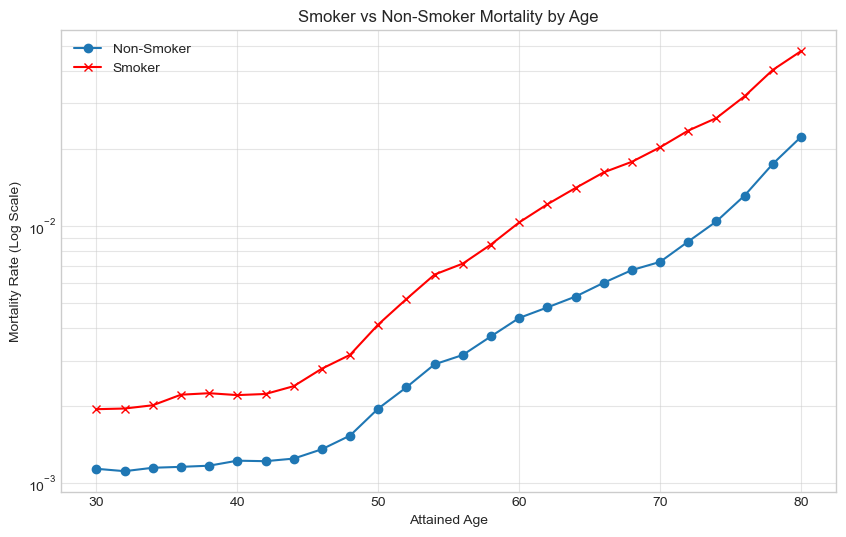

In [5]:
ages = np.arange(30, 81, 2)

# Non-Smoker Profile
ns_profile = std_profile.copy()
ns_profile['Smoker_Status'] = 'NS'

# Smoker Profile
s_profile = std_profile.copy()
s_profile['Smoker_Status'] = 'S'

def get_preds(range_vals, profile, feat='Attained_Age'):
    temp_df = pd.DataFrame([profile] * len(range_vals))
    temp_df[feat] = range_vals
    for col in CATEGORICAL_FEATURES:
        temp_df[col] = temp_df[col].astype('category')
    return model.predict(temp_df)

pred_ns = get_preds(ages, ns_profile)
pred_s = get_preds(ages, s_profile)

plt.figure(figsize=(10, 6))
plt.plot(ages, pred_ns, label='Non-Smoker', marker='o')
plt.plot(ages, pred_s, label='Smoker', marker='x', color='red')
plt.yscale('log')
plt.xlabel('Attained Age')
plt.ylabel('Mortality Rate (Log Scale)')
plt.title('Smoker vs Non-Smoker Mortality by Age')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.5)
plt.show()

## 4. Interpretability with SHAP (SHapley Additive exPlanations)

We use SHAP to explain the output of the LightGBM model. SHAP values allow us to understand the contribution of each feature to the prediction for every sample.

In [6]:
import shap

# Create object that can calculate shap values
# shap.initjs() # JS visualization might not render in static output but summary_plot works
explainer = shap.TreeExplainer(model)

# Calculate shap values for a sample
X_sample = X.sample(min(5000, len(X)), random_state=42)
shap_values = explainer(X_sample)

print(f'SHAP values calculated for {len(X_sample)} samples.')

SHAP values calculated for 5000 samples.


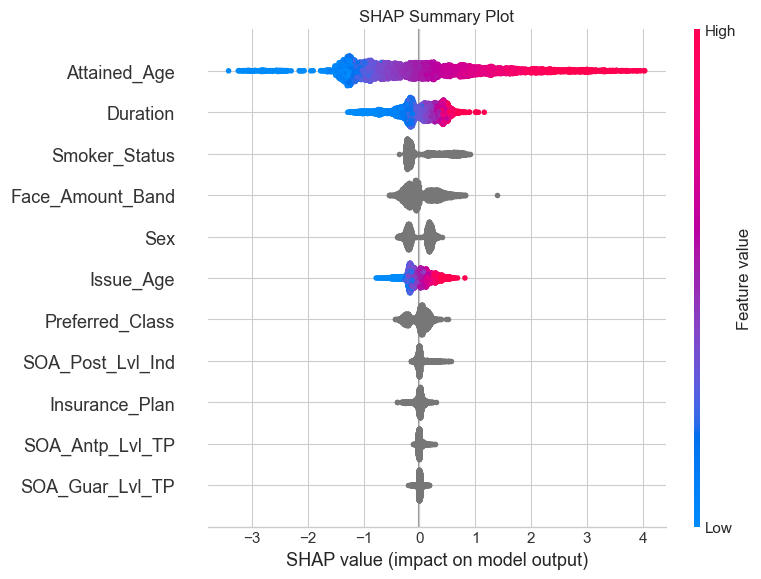

In [7]:
# SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
plt.title('SHAP Summary Plot')
shap.summary_plot(shap_values, X_sample, show=True)

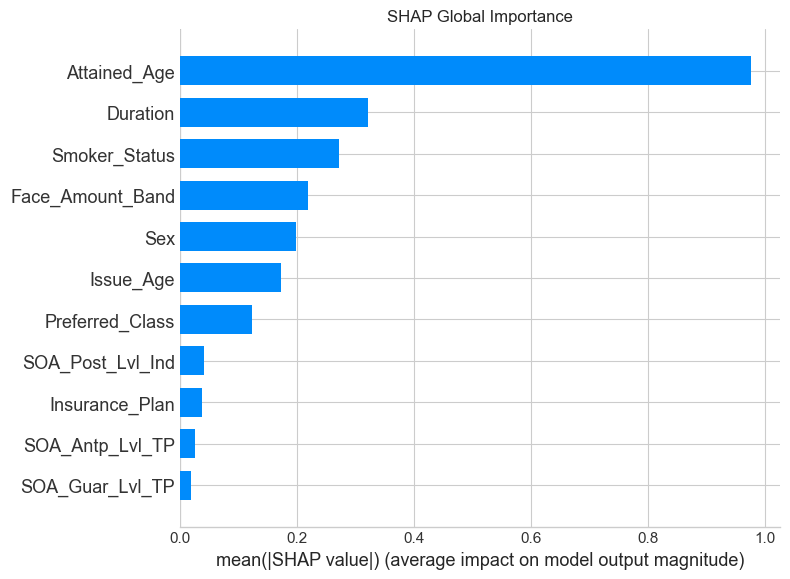

In [8]:
# SHAP Summary Plot (Bar - Global Importance)
plt.figure(figsize=(12, 8))
plt.title('SHAP Global Importance')
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=True)

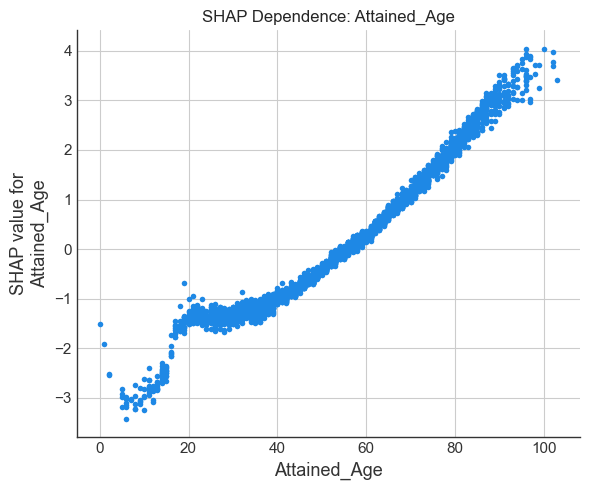

In [9]:
# SHAP Dependence Plot for Attained_Age
shap.dependence_plot('Attained_Age', shap_values.values, X_sample, interaction_index=None, show=False)
plt.title('SHAP Dependence: Attained_Age')
plt.tight_layout()
plt.show()

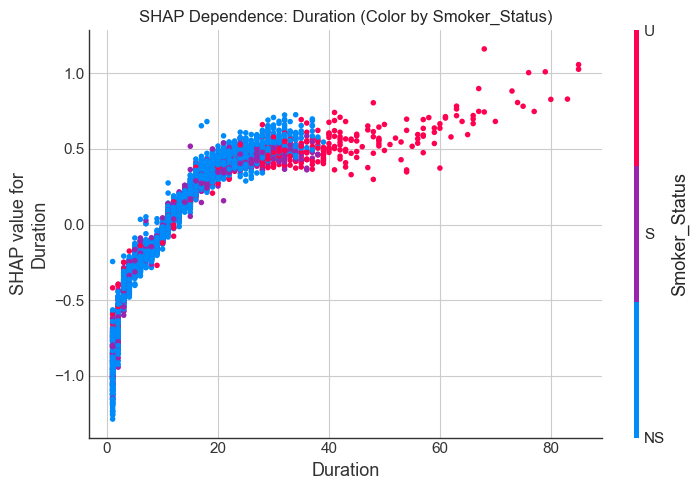

In [10]:
# SHAP Dependence Plot for Duration with Smoker Interaction
shap.dependence_plot('Duration', shap_values.values, X_sample, interaction_index='Smoker_Status', show=False)
plt.title('SHAP Dependence: Duration (Color by Smoker_Status)')
plt.tight_layout()
plt.show()

## 5. Feature Importance Consistency Check (Gain vs Split)

Comparing 'Gain' (contribution to loss reduction) vs 'Split' (number of times used in splits).

Comparing Gain vs Split Importance...
             feature       gain  split  gain_pct  split_pct
0       Attained_Age 6131377.27  10468     76.74      23.52
2           Duration  791912.25   8558      9.91      19.22
1          Issue_Age  577142.28   7924      7.22      17.80
4      Smoker_Status  173679.30   3338      2.17       7.50
6   Face_Amount_Band  161441.49   3563      2.02       8.00
3                Sex   71086.80   3249      0.89       7.30
5     Insurance_Plan   32366.48   2422      0.41       5.44
7    Preferred_Class   29738.19   2592      0.37       5.82
8   SOA_Post_Lvl_Ind   12928.67    912      0.16       2.05
9    SOA_Antp_Lvl_TP    4782.19    872      0.06       1.96
10   SOA_Guar_Lvl_TP    2923.27    618      0.04       1.39


/var/folders/2q/db42cqnn7nx7pvw9p0lf57hm0000gp/T/ipykernel_13995/2477726374.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gain_pct', y='feature', data=df_imp.sort_values('gain', ascending=False), ax=ax[0], palette='viridis')
/var/folders/2q/db42cqnn7nx7pvw9p0lf57hm0000gp/T/ipykernel_13995/2477726374.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='split_pct', y='feature', data=df_imp.sort_values('split', ascending=False), ax=ax[1], palette='magma')


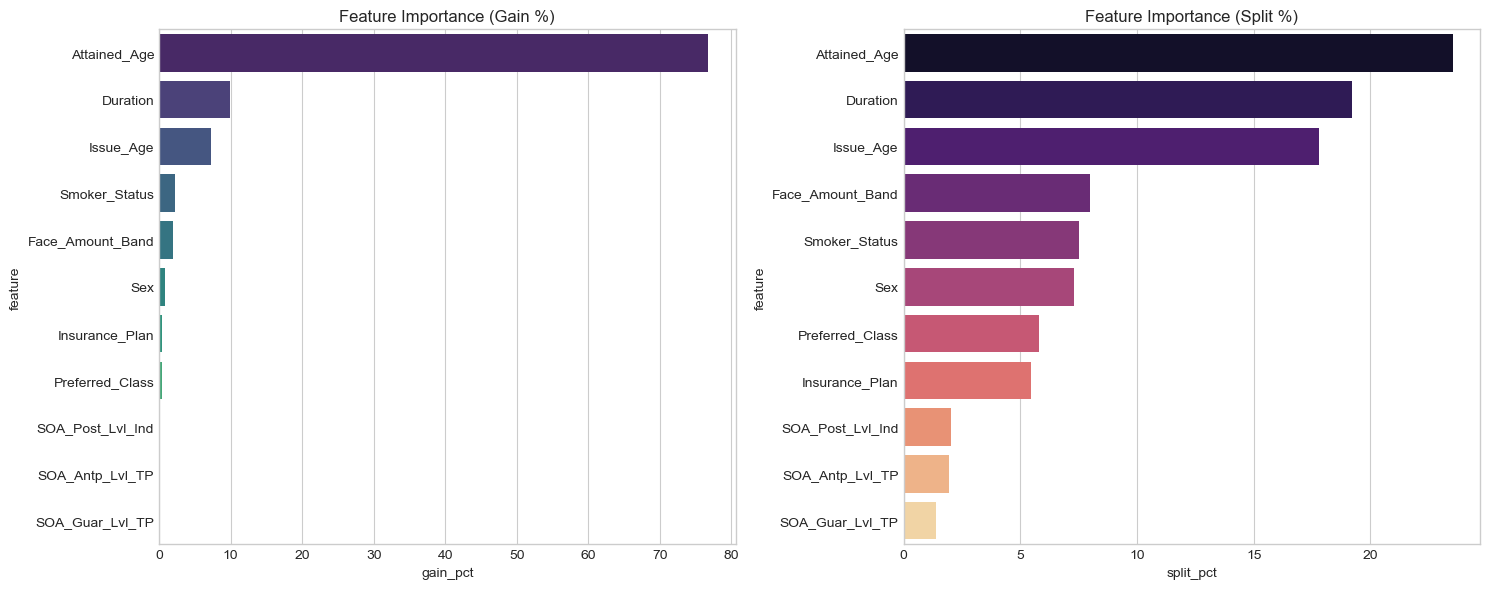

In [11]:
print("Comparing Gain vs Split Importance...")
df_imp = pd.DataFrame({'feature': model.feature_name(), 
                       'gain': model.feature_importance(importance_type='gain'),
                       'split': model.feature_importance(importance_type='split')})

df_imp['gain_pct'] = df_imp['gain'] / df_imp['gain'].sum() * 100
df_imp['split_pct'] = df_imp['split'] / df_imp['split'].sum() * 100
print(df_imp.sort_values('gain', ascending=False).to_string(float_format='%.2f'))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='gain_pct', y='feature', data=df_imp.sort_values('gain', ascending=False), ax=ax[0], palette='viridis')
ax[0].set_title('Feature Importance (Gain %)')
sns.barplot(x='split_pct', y='feature', data=df_imp.sort_values('split', ascending=False), ax=ax[1], palette='magma')
ax[1].set_title('Feature Importance (Split %)')
plt.tight_layout()
plt.show()

Plotting LGBM Tree...


Error plotting tree: You must install graphviz and restart your session to plot tree.


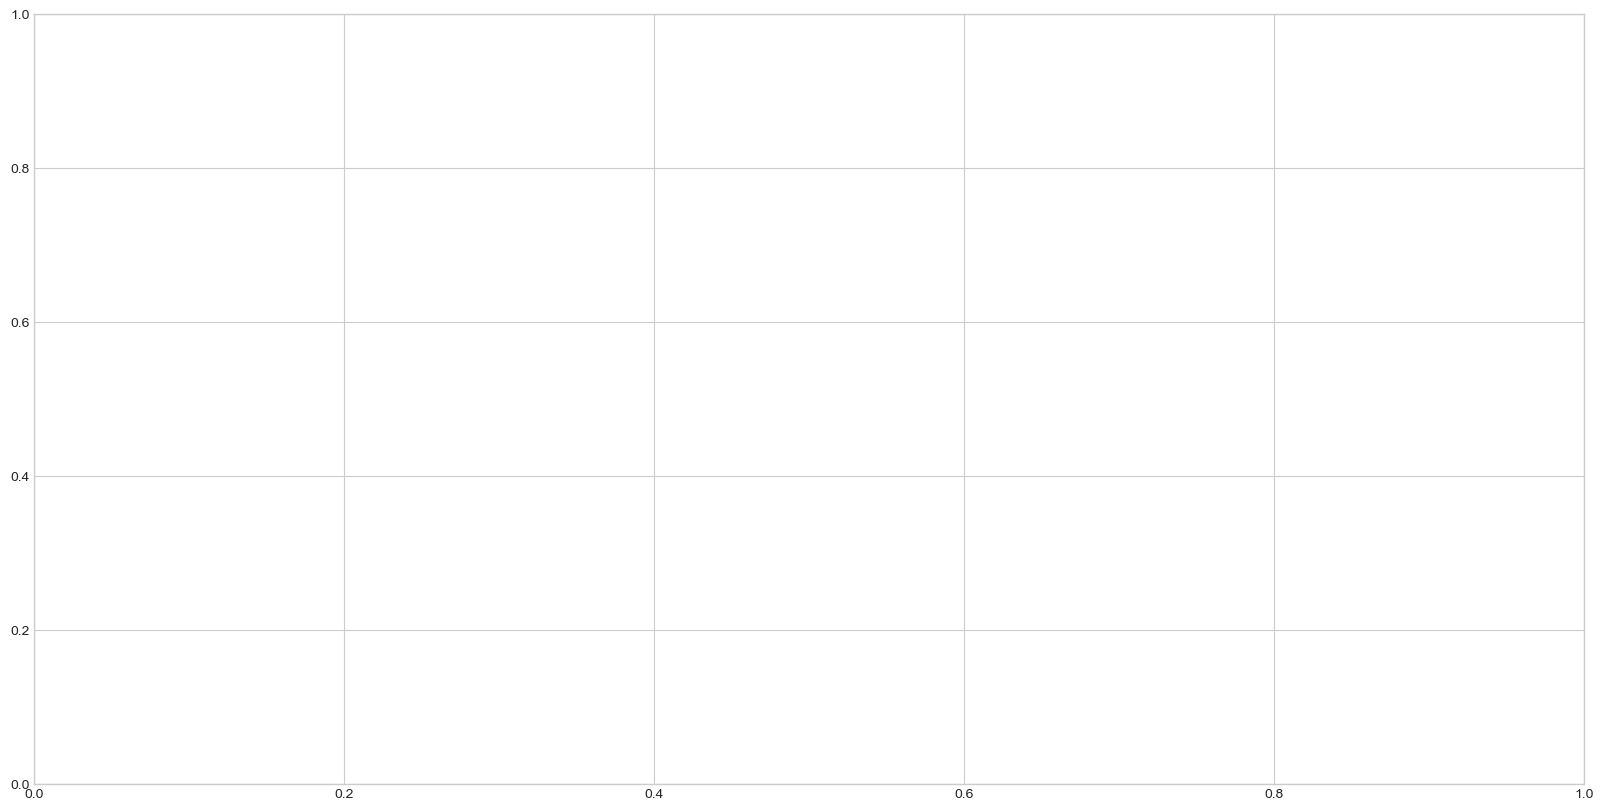

In [12]:
# Visualization of Tree #0
print("Plotting LGBM Tree...")
try:
    ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
    plt.title("LGBM Decision Tree (Tree #0)", fontsize=15)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting tree: {e}")

## 6. Large Scale Validation (500k samples per year)
Loading a larger, stratified sample to verify model performance stability.
NOTE: Table A/E is not computed as numerical table rates are not available in the dataset.
We focus on Model A/E (Actual / Model Predicted).

Loading data for stratified validation (500k per year)...


Sampling from years: [2012 2013 2014 2015 2016 2017 2018 2019]


Year 2012: 500000 samples


Year 2013: 500000 samples


Year 2014: 500000 samples


Year 2015: 500000 samples


Year 2016: 500000 samples


Year 2017: 500000 samples


Year 2018: 500000 samples


Year 2019: 500000 samples


Total Validation Set Size: 4000000


Running predictions...



--- Validation Results (N=4000000) ---
Total Actual Deaths: 421150.00
Total Model Predicted Deaths: 421354.54

Model A/E: 0.9995

Yearly A/E:
      Model A/E
Year           
2012     0.9981
2013     0.9935
2014     0.9980
2015     1.0133
2016     0.9767
2017     1.0095
2018     1.0189
2019     0.9926


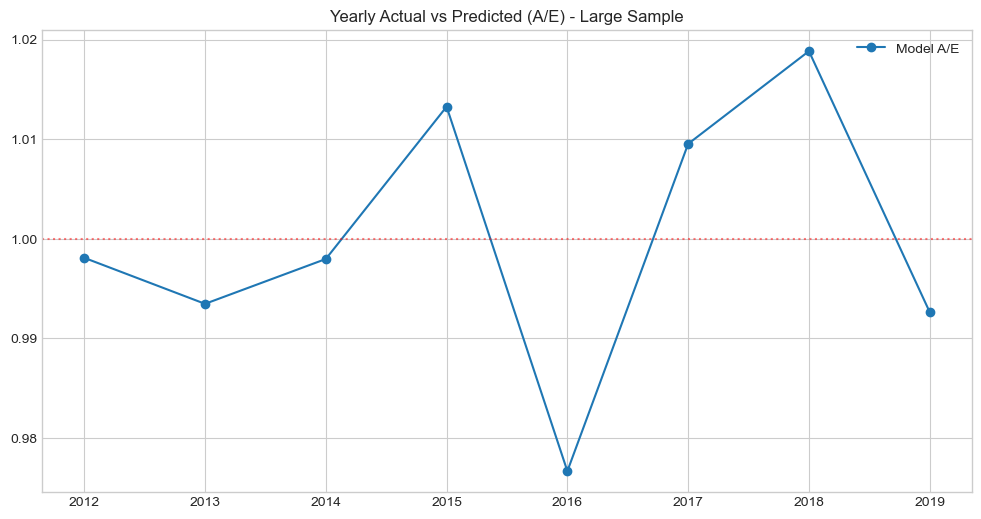

In [13]:
print("Loading data for stratified validation (500k per year)...")
try:
    # Use global DATA_PATH if available, else define it
    if 'DATA_PATH' not in locals():
        DATA_PATH = '../data/ilec_cleaned.parquet'
        
    df_full = pd.read_parquet(DATA_PATH)
    
    # Stratified Sampling by Observation_Year
    years = df_full['Observation_Year'].unique()
    dfs = []
    print(f"Sampling from years: {years}")
    for year in sorted(years):
        year_data = df_full[df_full['Observation_Year'] == year]
        n_samples = min(len(year_data), 500000)
        dfs.append(year_data.sample(n=n_samples, random_state=42))
        print(f"Year {year}: {n_samples} samples")

    df_val = pd.concat(dfs).reset_index(drop=True)
    print(f"Total Validation Set Size: {len(df_val)}")

    # Prepare Data
    X_val = df_val[NUMERICAL_FEATURES + CATEGORICAL_FEATURES].copy()
    for col in CATEGORICAL_FEATURES:
        X_val[col] = X_val[col].astype('category')
    
    # FIX: Use Death_Count, not Death_Indicator
    y_val = df_val['Death_Count']
    
    # FIX: Use Policies_Exposed as offset (Model trained with log(Exposure))
    # Model predicts Rate Adjustment (or Rate if trained on qx). 
    # With log(E) offset, raw_score=False gives E * exp(score).
    # So we want final_preds = E * exp(score).
    # Wait, lgb predict(raw_score=False) without init_score argument returns exp(score+0).
    # So we multiply by E manually.
    exposure_val = df_val['Policies_Exposed']

    # Predict
    print("Running predictions...")
    model_factor = model.predict(X_val, raw_score=False) 
    
    # Ensure numpy array
    model_factor = np.array(model_factor)
    
    final_preds = model_factor * exposure_val
    
    # Metrics
    total_actual = y_val.sum()
    total_pred = final_preds.sum()
    
    print(f"\n--- Validation Results (N={len(df_val)}) ---")
    print(f"Total Actual Deaths: {total_actual:.2f}")
    print(f"Total Model Predicted Deaths: {total_pred:.2f}")
    
    # Avoid div by zero
    model_ae = total_actual / total_pred if total_pred else 0

    print(f"\nModel A/E: {model_ae:.4f}")
    
    # Yearly A/E
    results_df = pd.DataFrame({
        'Year': df_val['Observation_Year'],
        'Actual': y_val,
        'Predicted': final_preds
    })
    yearly_ae = results_df.groupby('Year')[['Actual', 'Predicted']].sum()
    yearly_ae['Model A/E'] = yearly_ae['Actual'] / yearly_ae['Predicted']
    
    print("\nYearly A/E:")
    print(yearly_ae[['Model A/E']].to_string(float_format='%.4f'))
    
    # Plot Yearly A/E
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(yearly_ae.index, yearly_ae['Model A/E'], marker='o', label='Model A/E')
        plt.axhline(1.0, color='red', linestyle=':', alpha=0.5)
        plt.title('Yearly Actual vs Predicted (A/E) - Large Sample')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Plotting failed: {e}")

except Exception as e:
    print(f"Error in validation: {e}")
    import traceback
    traceback.print_exc()